# Train a Deep NN to predict Asset Price returns

In practice, we need to explore variations of the design options outlined above because we can rarely be sure from the outset which network architecture best suits the data.

In this section, we will explore various options to build a simple feedforward Neural Network to predict asset price returns for a one-day horizon.

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

import os, sys
from ast import literal_eval as make_tuple
from time import time
from pathlib import Path
from itertools import product
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import spearmanr
import seaborn as sns

from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation

In [3]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using CPU


In [4]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import MultipleTimeSeriesCV, format_time

In [5]:
np.random.seed(42)
sns.set_style('whitegrid')
idx = pd.IndexSlice

In [6]:
DATA_STORE = '../data/assets.h5'

In [7]:
results_path = Path('results')
if not results_path.exists():
    results_path.mkdir()
    
checkpoint_path = results_path / 'logs'

## Create a stock return series to predict asset price moves

To develop our trading strategy, we use the daily stock returns for some 995 US stocks for the eight year period from 2010 to 2017, and the features developed in Chapter 12 that include volatility and momentum factors as well as lagged returns with cross-sectional and sectoral rankings.

In [8]:
data = pd.read_hdf('../12_gradient_boosting_machines/data.h5', 'model_data').dropna()

In [9]:
outcomes = data.filter(like='fwd').columns.tolist()

In [10]:
lookahead = 1
outcome= f'r{lookahead:02}_fwd'

In [11]:
X_cv = data.loc[idx[:, :'2017'], :].drop(outcomes, axis=1)
y_cv = data.loc[idx[:, :'2017'], outcome]

In [12]:
len(X_cv.index.get_level_values('symbol').unique())

995

In [13]:
X_cv.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1911344 entries, ('A', Timestamp('2010-04-06 00:00:00')) to ('ZION', Timestamp('2017-11-29 00:00:00'))
Data columns (total 30 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   dollar_vol_rank  1911344 non-null  float64
 1   rsi              1911344 non-null  float64
 2   bb_high          1911344 non-null  float64
 3   bb_low           1911344 non-null  float64
 4   NATR             1911344 non-null  float64
 5   ATR              1911344 non-null  float64
 6   PPO              1911344 non-null  float64
 7   MACD             1911344 non-null  float64
 8   sector           1911344 non-null  int64  
 9   r01              1911344 non-null  float64
 10  r05              1911344 non-null  float64
 11  r10              1911344 non-null  float64
 12  r21              1911344 non-null  float64
 13  r42              1911344 non-null  float64
 14  r63              1911344 non-null  float6

## Automate model generation

The following `make_model` function illustrates how to flexibly define various architectural elements for the search process. The dense_layers argument defines both the depth and width of the network as a list of integers. We also use dropout for regularization, expressed as a float in the range [0, 1] to define the probability that a given unit will be excluded from a training iteration.

In [14]:
def make_model(dense_layers, activation, dropout):
    '''Creates a multi-layer perceptron model
    
    dense_layers: List of layer sizes; one number per layer
    '''

    model = Sequential()
    for i, layer_size in enumerate(dense_layers, 1):
        if i == 1:
            model.add(Dense(layer_size, input_dim=X_cv.shape[1]))
            model.add(Activation(activation))
        else:
            model.add(Dense(layer_size))
            model.add(Activation(activation))
    model.add(Dropout(dropout))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error',
                  optimizer='Adam')

    return model

## Cross-validate multiple configurations with TensorFlow

### Train-Test Split

We split the data into a training set for cross-validation, and keep the last 12 months with data as holdout test:

In [15]:
n_splits = 12
train_period_length=21 * 12 * 4
test_period_length=21 * 3

In [16]:
cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          train_period_length=train_period_length,
                          test_period_length=test_period_length,
                          lookahead=lookahead)

### Define CV Parameters

Now we just need to define our Keras classifier using the make_model function, set cross-validation (see chapter 6 on The Machine Learning Process and following for the OneStepTimeSeriesSplit), and the parameters that we would like to explore. 

We pick several one- and two-layer configurations, relu and tanh activation functions, and different dropout rates. We could also try out different optimizers (but did not run this experiment to limit what is already a computationally intensive effort):

In [17]:
dense_layer_opts = [(16, 8), (32, 16), (32, 32), (64, 32)]
activation_opts = ['tanh']
dropout_opts = [0, .1, .2]

In [18]:
param_grid = list(product(dense_layer_opts, activation_opts, dropout_opts))
np.random.shuffle(param_grid)

In [19]:
len(param_grid)

12

To trigger the parameter search, we instantiate a GridSearchCV object, define the fit_params that will be passed to the Keras model’s fit method, and provide the training data to the GridSearchCV fit method:

In [20]:
def get_train_valid_data(X, y, train_idx, test_idx):
    x_train, y_train = X.iloc[train_idx, :], y.iloc[train_idx]
    x_val, y_val = X.iloc[test_idx, :], y.iloc[test_idx]
    return x_train, y_train, x_val, y_val

In [21]:
ic = []
scaler = StandardScaler()
for params in param_grid:
    dense_layers, activation, dropout = params
    for batch_size in [64, 256]:
        print(dense_layers, activation, dropout, batch_size)
        checkpoint_dir = checkpoint_path / str(dense_layers) / activation / str(dropout) / str(batch_size)
        if not checkpoint_dir.exists():
            checkpoint_dir.mkdir(parents=True, exist_ok=True)
        start = time()
        for fold, (train_idx, test_idx) in enumerate(cv.split(X_cv)):
            x_train, y_train, x_val, y_val = get_train_valid_data(X_cv, y_cv, train_idx, test_idx)
            x_train = scaler.fit_transform(x_train)
            x_val = scaler.transform(x_val)
            preds = y_val.to_frame('actual')
            r = pd.DataFrame(index=y_val.groupby(level='date').size().index)
            model = make_model(dense_layers, activation, dropout)
            for epoch in range(20):            
                model.fit(x_train,
                          y_train,
                          batch_size=batch_size,
                          epochs=1,
                          verbose=0,
                          shuffle=True,
                          validation_data=(x_val, y_val))
                model.save_weights((checkpoint_path / f'ckpt_{fold}_{epoch}').as_posix())
                preds[epoch] = model.predict(x_val).squeeze()
                r[epoch] = preds.groupby(level='date').apply(lambda x: spearmanr(x.actual, x[epoch])[0]).to_frame(epoch)
                print(format_time(time()-start), f'{fold + 1:02d} | {epoch + 1:02d} | {r[epoch].mean():7.4f} | {r[epoch].median():7.4f}')
            ic.append(r.assign(dense_layers=str(dense_layers), 
                               activation=activation, 
                               dropout=dropout,
                               batch_size=batch_size,
                               fold=fold))       

        t = time()-start
        pd.concat(ic).to_hdf(results_path / 'scores.h5', 'ic_by_day')

(64, 32) tanh 0.1 64
00:00:34 01 | 01 |  0.0116 |  0.0166
00:01:05 01 | 02 |  0.0174 |  0.0028
00:01:36 01 | 03 | -0.0008 | -0.0062
00:02:06 01 | 04 |  0.0057 |  0.0022
00:02:35 01 | 05 |  0.0192 |  0.0105
00:03:04 01 | 06 | -0.0035 | -0.0078
00:03:34 01 | 07 |  0.0168 |  0.0126
00:04:03 01 | 08 | -0.0033 | -0.0097
00:04:33 01 | 09 |  0.0175 |  0.0349
00:05:02 01 | 10 |  0.0251 |  0.0180
00:05:33 01 | 11 |  0.0199 |  0.0259
00:06:02 01 | 12 |  0.0159 |  0.0193
00:06:32 01 | 13 |  0.0209 |  0.0296
00:07:02 01 | 14 |  0.0135 |  0.0063
00:07:32 01 | 15 |  0.0196 |  0.0236
00:08:02 01 | 16 |  0.0150 |  0.0021
00:08:31 01 | 17 |  0.0090 |  0.0117
00:09:01 01 | 18 |  0.0117 | -0.0076
00:09:30 01 | 19 |  0.0221 |  0.0186
00:09:60 01 | 20 |  0.0226 |  0.0212
00:10:31 02 | 01 |  0.0007 |  0.0135
00:11:02 02 | 02 | -0.0178 | -0.0067
00:11:33 02 | 03 |  0.0203 |  0.0337
00:12:02 02 | 04 |  0.0076 | -0.0305
00:12:32 02 | 05 | -0.0037 | -0.0065
00:13:02 02 | 06 | -0.0072 | -0.0106
00:13:33 02 | 07 

KeyboardInterrupt: 

### Evaluate predictive performance

In [22]:
params = ['dense_layers', 'dropout', 'batch_size']

In [23]:
ic = pd.read_hdf(results_path / 'scores.h5', 'ic_by_day').drop('activation', axis=1)
ic.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 756 entries, 2017-08-30 to 2015-03-02
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   0             756 non-null    float64
 1   1             756 non-null    float64
 2   2             756 non-null    float64
 3   3             756 non-null    float64
 4   4             756 non-null    float64
 5   5             756 non-null    float64
 6   6             756 non-null    float64
 7   7             756 non-null    float64
 8   8             756 non-null    float64
 9   9             756 non-null    float64
 10  10            756 non-null    float64
 11  11            756 non-null    float64
 12  12            756 non-null    float64
 13  13            756 non-null    float64
 14  14            756 non-null    float64
 15  15            756 non-null    float64
 16  16            756 non-null    float64
 17  17            756 non-null    float64
 18  18         

In [24]:
ic.groupby(params).size()

dense_layers  dropout  batch_size
(64, 32)      0.1      64            756
dtype: int64

In [25]:
ic_long = pd.melt(ic, id_vars=params + ['fold'], var_name='epoch', value_name='ic')
ic_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15120 entries, 0 to 15119
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   dense_layers  15120 non-null  object 
 1   dropout       15120 non-null  float64
 2   batch_size    15120 non-null  int64  
 3   fold          15120 non-null  int64  
 4   epoch         15120 non-null  object 
 5   ic            15120 non-null  float64
dtypes: float64(2), int64(2), object(2)
memory usage: 708.9+ KB


In [26]:
ic_long = ic_long.groupby(params+ ['epoch', 'fold']).ic.mean().to_frame('ic').reset_index()

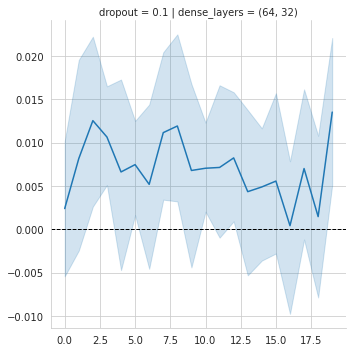

In [27]:
g = sns.relplot(x='epoch', y='ic', col='dense_layers', row='dropout', 
                data=ic_long[ic_long.dropout>0], kind='line')
g.map(plt.axhline, y=0, ls='--', c='k', lw=1)
g.savefig(results_path / 'ic_lineplot', dpi=300);

In [28]:
def run_ols(ic):
    ic.dense_layers = ic.dense_layers.str.replace(', ', '-').str.replace('(', '').str.replace(')', '')
    data = pd.melt(ic, id_vars=params, var_name='epoch', value_name='ic')
    data.epoch = data.epoch.astype(int).astype(str).apply(lambda x: f'{int(x):02.0f}')
    model_data = pd.get_dummies(data.sort_values(params + ['epoch']), columns=['epoch'] + params, drop_first=True).sort_index(1)
    model_data.columns = [s.split('_')[-1] for s in model_data.columns]
    model = sm.OLS(endog=model_data.ic, exog=sm.add_constant(model_data.drop('ic', axis=1)))
    return model.fit()

In [29]:
model = run_ols(ic.drop('fold', axis=1))

In [30]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                     ic   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.5881
Date:                Wed, 24 Feb 2021   Prob (F-statistic):              0.918
Time:                        16:31:27   Log-Likelihood:                 9612.0
No. Observations:               15120   AIC:                        -1.918e+04
Df Residuals:                   15100   BIC:                        -1.903e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0024      0.005      0.514      0.6

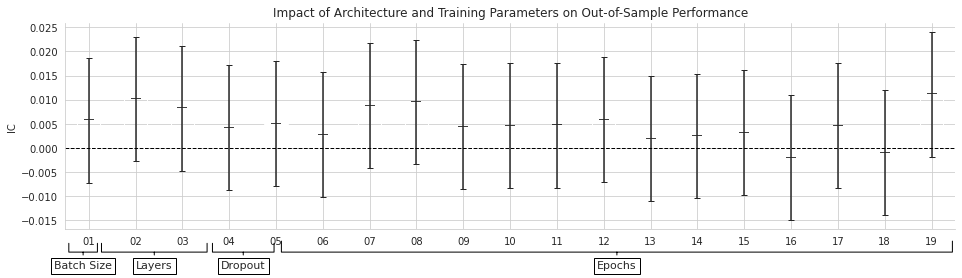

In [31]:
fig, ax = plt.subplots(figsize=(14, 4))

ci = model.conf_int()
errors = ci[1].sub(ci[0]).div(2)

coefs = (model.params.to_frame('coef').assign(error=errors)
         .reset_index().rename(columns={'index': 'variable'}))
coefs = coefs[~coefs['variable'].str.startswith('date') & (coefs.variable != 'const')]

coefs.plot(x='variable', y='coef', kind='bar',
           ax=ax, color='none', capsize=3,
           yerr='error', legend=False, rot=0, title='Impact of Architecture and Training Parameters on Out-of-Sample Performance')
ax.set_ylabel('IC')
ax.set_xlabel('')
ax.scatter(x=pd.np.arange(len(coefs)), marker='_', s=120, y=coefs['coef'], color='black')
ax.axhline(y=0, linestyle='--', color='black', linewidth=1)
ax.xaxis.set_ticks_position('none')

ax.annotate('Batch Size', xy=(.02, -0.1), xytext=(.02, -0.2),
            xycoords='axes fraction',
            textcoords='axes fraction',
            fontsize=11, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white', ec='black'),
            arrowprops=dict(arrowstyle='-[, widthB=1.3, lengthB=0.8', lw=1.0, color='black'))

ax.annotate('Layers', xy=(.1, -0.1), xytext=(.1, -0.2),
            xycoords='axes fraction',
            textcoords='axes fraction',
            fontsize=11, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white', ec='black'),
            arrowprops=dict(arrowstyle='-[, widthB=4.8, lengthB=0.8', lw=1.0, color='black'))

ax.annotate('Dropout', xy=(.2, -0.1), xytext=(.2, -0.2),
            xycoords='axes fraction',
            textcoords='axes fraction',
            fontsize=11, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white', ec='black'),
            arrowprops=dict(arrowstyle='-[, widthB=2.8, lengthB=0.8', lw=1.0, color='black'))

ax.annotate('Epochs', xy=(.62, -0.1), xytext=(.62, -0.2),
            xycoords='axes fraction',
            textcoords='axes fraction',
            fontsize=11, ha='center', va='bottom',
            bbox=dict(boxstyle='square', fc='white', ec='black'),
            arrowprops=dict(arrowstyle='-[, widthB=30.5, lengthB=1.0', lw=1.0, color='black'))

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'ols_coef', dpi=300)

## Make Predictions

In [32]:
def get_best_params(n=5):
    """Get the best parameters across all folds by daily median IC"""
    params = ['dense_layers', 'activation', 'dropout', 'batch_size']
    ic = pd.read_hdf(results_path / 'scores.h5', 'ic_by_day').drop('fold', axis=1)
    dates = sorted(ic.index.unique())
    train_period = 24 * 21
    train_dates = dates[:train_period]
    ic = ic.loc[train_dates]
    return (ic.groupby(params)
            .median()
            .stack()
            .to_frame('ic')
            .reset_index()
            .rename(columns={'level_4': 'epoch'})
            .nlargest(n=n, columns='ic')
            .drop('ic', axis=1)
            .to_dict('records'))

In [33]:
def generate_predictions(dense_layers, activation, dropout, batch_size, epoch):
    data = pd.read_hdf('../12_gradient_boosting_machines/data.h5', 'model_data').dropna()
    outcomes = data.filter(like='fwd').columns.tolist()
    X_cv = data.loc[idx[:, :'2017'], :].drop(outcomes, axis=1)
    input_dim = X_cv.shape[1]
    y_cv = data.loc[idx[:, :'2017'], 'r01_fwd']

    scaler = StandardScaler()
    predictions = []
    
    do = '0' if str(dropout) == '0.0' else str(dropout)
    checkpoint_dir = checkpoint_path / dense_layers / activation / do / str(batch_size)
        
    for fold, (train_idx, test_idx) in enumerate(cv.split(X_cv)):
        x_train, y_train, x_val, y_val = get_train_valid_data(X_cv, y_cv, train_idx, test_idx)
        x_val = scaler.fit(x_train).transform(x_val)
        model = make_model(make_tuple(dense_layers), activation, dropout)
        status = model.load_weights((checkpoint_dir / f'ckpt_{fold}_{epoch}').as_posix())
        status.expect_partial()
        predictions.append(pd.Series(model.predict(x_val).squeeze(), index=y_val.index))
    return pd.concat(predictions)        

In [34]:
best_params = get_best_params()
predictions = []
for i, params in enumerate(best_params):
    predictions.append(generate_predictions(**params).to_frame(i))

predictions = pd.concat(predictions, axis=1)
print(predictions.info())
predictions.to_hdf(results_path / 'test_preds.h5', 'predictions')

NotFoundError: Unsuccessful TensorSliceReader constructor: Failed to find any matching files for results/logs/(64, 32)/tanh/0.1/64/ckpt_0_7

### How to further improve the results

The relatively simple architecture yields some promising results. To further improve performance, you can
- First and foremost, add new features and more data to the model
- Expand the set of architectures to explore, including more or wider layers
- Inspect the training progress and train for more epochs if the validation error continued to improve at 50 epochs

Finally, you can use more sophisticated architectures, including Recurrent Neural Networks (RNN) and Convolutional Neural Networks that are well suited to sequential data, whereas vanilla feedforward NNs are not designed to capture the ordered nature of the features.
